# Demo #

Below we show a simple process for fitting and projecting a financial time series using `phat`. This example will utilize end-of-day daily prices of Coca-Cola, for which there is data back to 1962. The process is as follows:

+ download the daily prices of Coca-Cola (ticker: KO). Find the daily returns in percentage terms (i.e. x 100).
+ use the `arch` package to fit a GARCH(1,1) model to the daily returns
+ use the Hill double bootstrap method to estimate the tail index of both tails of the standardized residuals of the GARCH fit.
+ use `phat` custom data class, `DataSplit`, to split the data into training, testing, and validation subsets. *Be careful to scale by 1/10.*
+ use `PhatNet` and `phat`'s custom loss function `PhatLoss` to fit the remaining parameters.
+ use `Garchcaster` to produce 10,000 simulations of a one-year forecast via the same AR-GARCH model.

### Download Data ###

In [4]:
import yfinance as yf
import arch

import phat as ph

ko = yf.download('KO')
ko_ret = ko.Close.pct_change().dropna()*100
ko_ret = ko_ret[-252*10:]

[*********************100%***********************]  1 of 1 completed


### Fit GARCH and Estimate $\alpha$ in Both Tails ###

In [5]:
res = arch.arch_model(ko_ret, mean='Constant', vol='Garch', p=1, q=1).fit(disp='off')
xi_left, xi_right = ph.two_tailed_hill_double_bootstrap(res.std_resid)

  0%|          | 0/10 [00:00<?, ?it/s]

### Fit $\mu$ and $\sigma$ with Machine Learning ###

In [7]:
data = ph.DataSplit(res.std_resid[2:]/10)
pnet = ph.PhatNet(neurons=1)
pnet.compile(
    loss = ph.PhatLoss(xi_left,xi_right), 
    optimizer = 'adam'
)
history = pnet.fit(data.train, validation_data=data.test, epochs=100, verbose=0)

Epoch 00046: early stopping


The training process above results in the following estimated parameters for the standardized GARCH residuals.

In [8]:
pnet.predicted_params()

,
mean,0.009800
sig,0.034620
shape_l,0.346772
shape_r,0.285840


### Compare Fit with Gaussian and T ###

Below we compare the fit of the Phat distribution to that of the Gaussian and the Student's T. Note the Student's T fits to $v=4.65$, which is equivalent to $\xi = 0.22$, which is a thinner tail than found through the Hill Double bootstrap, particularly for the left tail.

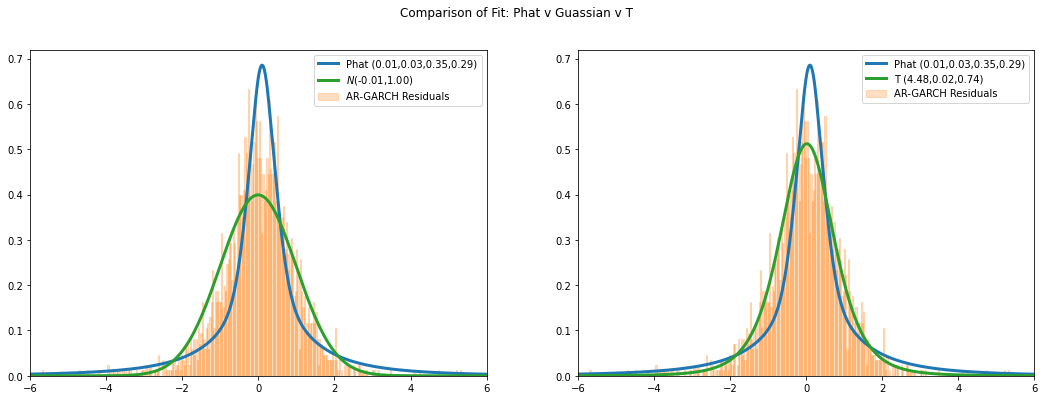

In [13]:
import numpy as np
import scipy.stats as scist
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
mu, sig, l, r = pnet.predicted_params().values.flatten()
phatdist = ph.Phat(mu*10, sig*10, l, r)

x = np.linspace(-6,6,1000)
counts, bins, _ = ax1.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'
)
ax1.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')

norm_params = scist.norm.fit(data.raw.y*10)
norm_label = ','.join([f'{p:.2f}' for p in norm_params])
ax1.plot(x, scist.norm(*norm_params).pdf(x), c='C2', lw=3, label=r'$N$' f'({norm_label})')
ax1.set_xlim(-6, 6)

counts, bins, _ = ax2.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'    
)
ax2.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')

t_params = scist.t.fit(data.raw.y*10)
t_label = ','.join([f'{p:.2f}' for name, p in zip([r'$v$', 'loc', 'scale'], t_params)])
ax2.plot(x, scist.t(*t_params).pdf(x), c='C2', lw=3, label=f'T ({t_label})')
ax2.set_xlim(-6, 6)

ax1.legend()
ax2.legend()

plt.suptitle('Comparison of Fit: Phat v Guassian v T')

plt.show()

The Phat distribution is a better fit to the peak of the distribution while both the Gaussian and Student's T are better fits in the shoulders. The devil, of course, is in the tails.

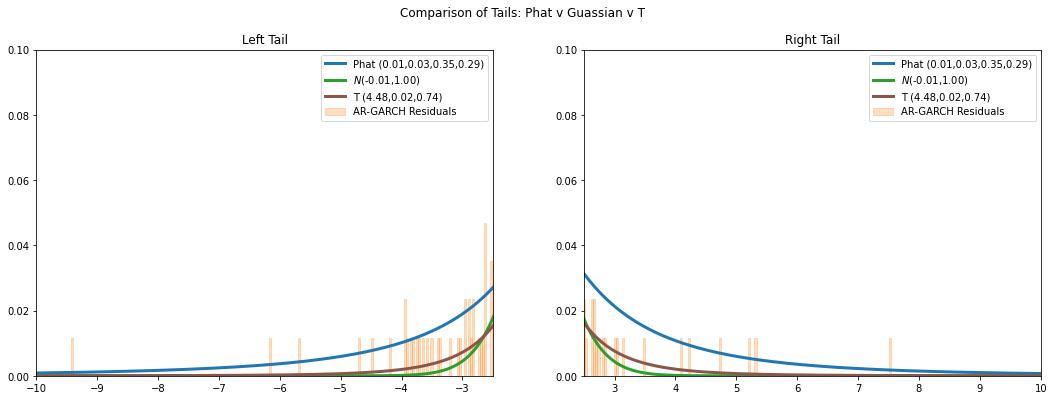

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
mu, sig, l, r = pnet.predicted_params().values.flatten()
phatdist = ph.Phat(mu*10, sig*10, l, r)

x = np.linspace(-10,-2,1000)
counts, bins, _ = ax1.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'
)
ax1.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')

norm_params = scist.norm.fit(data.raw.y*10)
norm_label = ','.join([f'{p:.2f}' for p in norm_params])
t_params = scist.t.fit(data.raw.y*10)
t_label = ','.join([f'{p:.2f}' for name, p in zip([r'$v$', 'loc', 'scale'], t_params)])

ax1.plot(x, scist.norm(*norm_params).pdf(x), c='C2', lw=3, label=r'$N$' f'({norm_label})')
ax1.plot(x, scist.t(*t_params).pdf(x), c='C5', lw=3, label=f'T ({t_label})')
ax1.set_xlim(-10,-2.5)
ax1.set_ylim(0,.1)

x = np.linspace(2,10,1000)
counts, bins, _ = ax2.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'    
)
ax2.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')
ax2.plot(x, scist.norm(*norm_params).pdf(x), c='C2', lw=3, label=r'$N$' f'({norm_label})')
ax2.plot(x, scist.t(*t_params).pdf(x), c='C5', lw=3, label=f'T ({t_label})')
ax2.set_xlim(2.5,10)
ax2.set_ylim(0,.1)

ax1.legend()
ax2.legend()
ax1.set_title('Left Tail')
ax2.set_title('Right Tail')

plt.suptitle('Comparison of Tails: Phat v Guassian v T')

plt.show()

Out in the left and right tails we see the Phat distribution is much better at capturing extreme events that have occured in the past 10 years.

### Generate Garch Forecasts ###

We can then feed this distribution, along with the results from the AR-GARCH fit, into the `Garchcaster`.

In [15]:
n = 10000
days = 252

mu, sig, l, r = pnet.predicted_params().values
phatdist = ph.Phat(mu*10, sig*10, l, r)
fore = ph.Garchcaster(
    garch=res,
    iters=n,
    periods=days,
    order=(0,0,1,1),
    dist=phatdist
).forecast()

Calling the `forecast` method results in 10,000 separate AR-GARCH simulations, each spanning 252 trading days. A `GarchcastResults` container is returned, which includes some plotting methods for convenience.

We can see the conditional variance of the resulting forecasts.

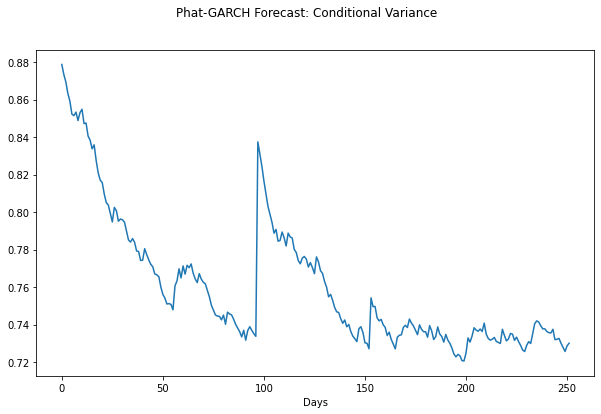

In [16]:
fore.plot('var')
plt.show()

We can plot individual simulations.

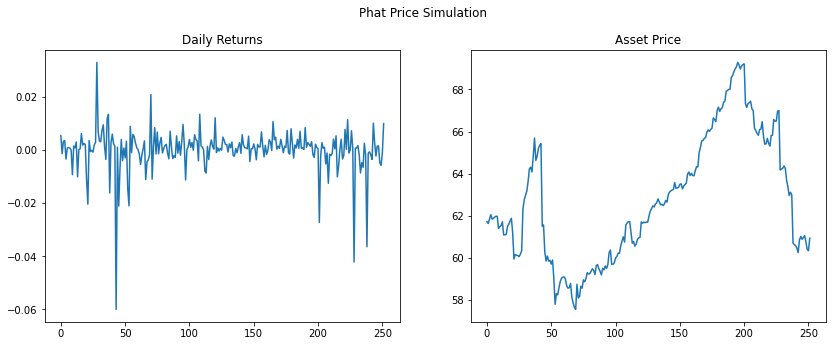

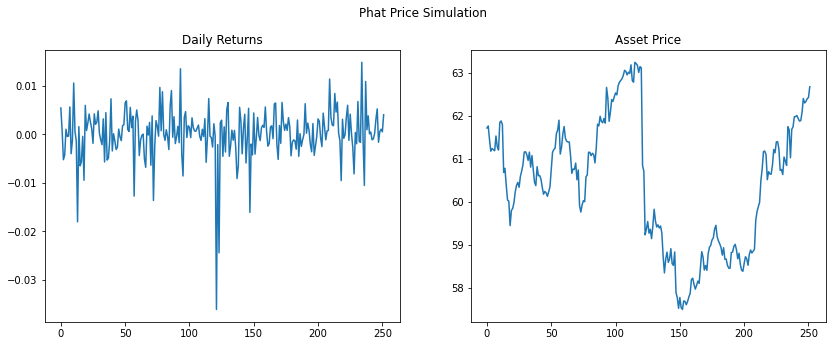

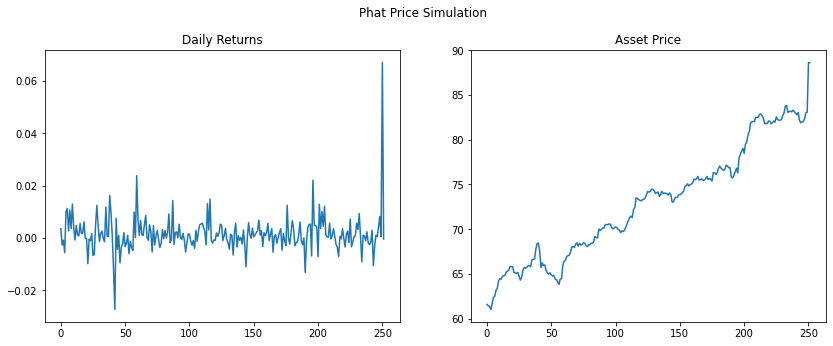

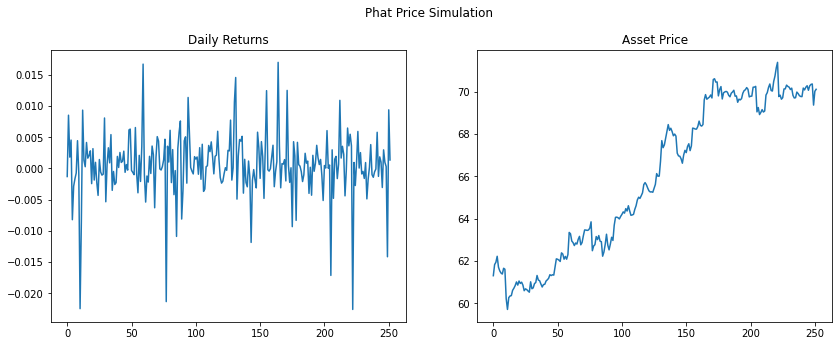

In [17]:
fore.plot('price', p=ko.Close[-1], n=4)
plt.show()

And we can plot a histogram of the final price in each simulation.

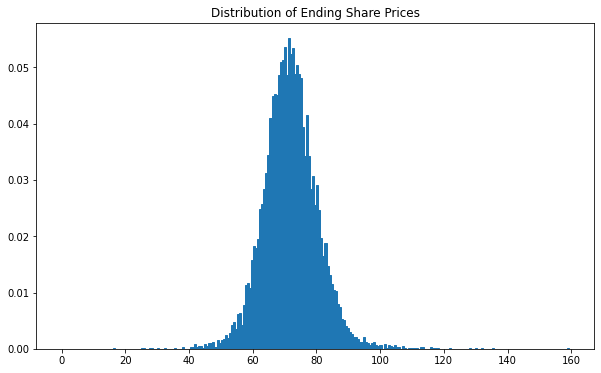

In [18]:
ax, P, bins = fore.plot('end_price', p=ko.Close[-1], ec='C0')
plt.show()